In [1]:
import os
import io
import platform
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
from PIL import ImageOps

In [2]:
FILE_PATH='./LAG/'
index=[]
def load_data():
    data=[]
    for directory in os.listdir(FILE_PATH):
        if not(directory.startswith('.')):
            young=[]
            old=[]
            temp=[]
            path=FILE_PATH+directory
            for g_img in os.listdir(path):
                path1=path+'/'+g_img
                copy_g=g_img
                if not(g_img.startswith('.')) and os.path.splitext(copy_g)[1]=='.png':
                    old.append(Image.open(path1).convert('RGB'))
                elif not(g_img.startswith('.')):
                    for y_img in os.listdir(path1):
                        if not (y_img.startswith('.')):
                            young.append(Image.open(path1+'/'+y_img).convert('RGB'))
            temp.append(old)
            temp.append(young)
            data.append(temp)
    return data

In [3]:
data=load_data()

In [4]:
dataset=[]
for i in range(0,len(data)):
    olds=data[i][0]
    youngs=data[i][1]
    for old in olds:
        for young in youngs:
            temp=[transforms.ToTensor()(old),transforms.ToTensor()(young)]
            dataset.append(temp)

In [5]:
dataset[0]

[tensor([[[ 0.9176,  0.9137,  0.9098,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.9176,  0.9137,  0.9098,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.9176,  0.9176,  0.9137,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.1333,  0.1412,  0.1255,  ...,  0.2039,  0.1922,  0.2196],
          [ 0.1412,  0.1333,  0.1059,  ...,  0.2118,  0.2118,  0.2039],
          [ 0.2000,  0.1647,  0.1020,  ...,  0.2000,  0.2353,  0.2078]],
 
         [[ 0.9176,  0.9137,  0.9098,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.9176,  0.9137,  0.9098,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.9176,  0.9176,  0.9137,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.1333,  0.1412,  0.1255,  ...,  0.1216,  0.1059,  0.1255],
          [ 0.1412,  0.1333,  0.1059,  ...,  0.1216,  0.1216,  0.1137],
          [ 0.2000,  0.1647,  0.1020,  ...,  0.1098,  0.1451,  0.1176]],
 
         [[ 0.9176,  0.9137,  0.9098,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.9176,  0.9137,

In [6]:
train,test=train_test_split(dataset,test_size=0.2,shuffle=True)

In [7]:
train,valid=train_test_split(train,test_size=0.25,shuffle=True)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cl1=nn.Conv2d(3,12,kernel_size=5,padding=2) # tunable here
        self.mp1=nn.MaxPool2d(2)
        self.cl2=nn.Conv2d(12,3,kernel_size=5,padding=2)
        self.mp2=nn.MaxPool2d(2)
        self.fcl=nn.Linear(7500,200) # 12 x 27 x 27
        
    def forward(self,x):
        # x dim: b x 800 x 600 x 3 -> b x 1 x 100 x 100
        out=F.relu(self.cl1(x))
        out=self.mp1(out)
        out=F.relu(self.cl2(out))
        out=self.mp2(out)
        
        # tensor size of b x inchannels x 1 x 1
        out=out.view(out.size(0),-1)
        out=F.sigmoid(self.fcl(out))
        return out

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(torch.pow(euclidean_distance, 2) +
                                      torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

#         loss_contrastive=torch.mean(torch.pow(euclidean_distance,2))
        return loss_contrastive

In [10]:
model=CNN()
model.eval()
optimizer=optim.Adam(model.parameters(),lr=0.0001,weight_decay=0.0001)
criterion=ContrastiveLoss()

In [11]:
def trainCNN(epoch,model,train_loader,optimizer):
    model.train()
    
    total_loss=0
    correct=0
    
    for i, (image,label) in enumerate(train_loader):
        optimizer.zero_grad() # initialize   
        prediction1=model(image)
        prediction2=model(label)
        loss=criterion(prediction1,prediction2)
#         print(loss)
        loss.backward()
        optimizer.step()
        total_loss+=loss # update loss
#         pred_classes=prediction1.data.max(1,keepdim=True)[1]
#         correct+=pred_classes.eq(prediction2.long().data.view_as(pred_classes)).sum().double()
        
    mean_loss=total_loss/len(train_loader.dataset)
#     acc=correct/len(train_loader.dataset)
    
    print('Train Epoch: {}   Avg_Loss: {:.5f}'.format(
        epoch, mean_loss))
    return mean_loss

In [12]:
def evalCNN(model,test_loader):
    model.eval()
    
    total_loss=0
    correct=0
    
    for i, (image,label) in enumerate(test_loader):
        optimizer.zero_grad() # initialize 
        prediction1=model(image)
        prediction2=model(label)
        loss=criterion(prediction1,prediction2)
        loss.backward()
        optimizer.step()
        total_loss+=loss # update loss
#         pred_classes=prediction1.data.max(1,keepdim=True)[1]
#         correct+=pred_classes.eq(prediction2.long().data.view_as(pred_classes)).sum().double()
        
    mean_loss=total_loss/len(test_loader.dataset)
#     acc=correct/len(test_loader.dataset)
    
    print('Eval:   Avg_Loss: {:.5f}'.format(
         mean_loss))

    return mean_loss

In [13]:
def save_model(epoch, model, path='./'):
    filename=path+'model.pt'
    torch.save(model.state_dict(), filename)
    return model

def load_model(epoch, model, path='./'):
#     torch.save(model.state_dict(), filename)
    return model

In [14]:
class LAGDataset(Dataset):
    """LAG dataset."""

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir,
#                                 self.landmarks_frame.iloc[idx, 0])
#         image = io.imread(img_name)
#         landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
#         landmarks = landmarks.astype('float').reshape(-1, 2)
#         sample = {'image': image, 'landmarks': landmarks}

#         if self.transform:
#             sample = self.transform(sample)
        
        img=self.data[idx]

        return (img[0],img[1])

In [15]:
train_set=LAGDataset(train)
valid_set=LAGDataset(valid)
test_set=LAGDataset(test)

In [16]:
BATCH_SIZE=100
train_loader=torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid_set,batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)

In [17]:
num_epoch=10
checkpoint_freq=5
path="./"

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

# traininng 
for epoch in range(1, num_epoch + 1):
    
    # train() function (see above)
    train_loss = trainCNN(epoch, model, train_loader, optimizer)
    
    # eval() functionn (see above)
    test_loss = evalCNN(model, test_loader)    
    
    # append lists for plotting and printing 
    train_losses.append(train_loss)    
    test_losses.append(test_loss)
    
#     train_accuracies.append(train_acc)    
#     test_accuracies.append(test_acc)
    
    # Checkpoint
    if epoch % checkpoint_freq == 0:
        save_model(epoch, model, path)

# Last checkpoint
save_model(num_epoch, model, path)
    
print("\n\n\nOptimization ended.\n") 

Train Epoch: 1   Avg_Loss: 0.02769
Eval:   Avg_Loss: 0.02437
Train Epoch: 2   Avg_Loss: 0.02224
Eval:   Avg_Loss: 0.02330
Train Epoch: 3   Avg_Loss: 0.02159
Eval:   Avg_Loss: 0.02283
Train Epoch: 4   Avg_Loss: 0.02126
Eval:   Avg_Loss: 0.02251
Train Epoch: 5   Avg_Loss: 0.02106
Eval:   Avg_Loss: 0.02233
Train Epoch: 6   Avg_Loss: 0.02090
Eval:   Avg_Loss: 0.02217
Train Epoch: 7   Avg_Loss: 0.02080
Eval:   Avg_Loss: 0.02213
Train Epoch: 8   Avg_Loss: 0.02073
Eval:   Avg_Loss: 0.02204
Train Epoch: 9   Avg_Loss: 0.02068
Eval:   Avg_Loss: 0.02198
Train Epoch: 10   Avg_Loss: 0.02064
Eval:   Avg_Loss: 0.02198



Optimization ended.



In [18]:
img1=transforms.ToTensor()(Image.open('./LAG/stas_mikhailov/Aprile_01891_1.png').convert('RGB'))
img2=transforms.ToTensor()(Image.open('./LAG/stas_mikhailov/y/Aprile_01891_2.png').convert('RGB'))

In [19]:
p1=model(img1.unsqueeze(0))
p2=model(img2.unsqueeze(0))

In [20]:
loss=criterion(p1,p2)

In [21]:
loss

tensor(2.0030)

In [ ]:
total_loss=0
for i, (old,young) in enumerate(valid_loader):
    prediction1=model(old)
    prediction2=model(young)
    loss=criterion(prediction1,prediction2)
    total_loss+=loss
mean_loss=total_loss/len(valid_loader.dataset)
print(mean_loss)

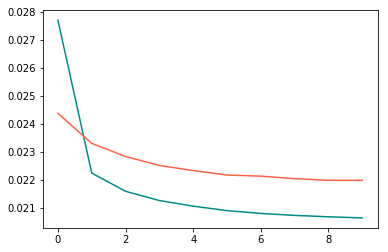

In [3]:
import os
import io
import matplotlib.pyplot as plt

train_losses=[0.02769,0.02224,0.02159,0.02126,0.02106,0.02090,0.02080,0.02073,0.02068,0.02064]
valid_losses=[0.02437,0.02330,0.02283,0.02251,0.02233,0.02217,0.02213,0.02204,0.02198,0.02198]

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()